In [1]:
# Playgroud Series - Binary Classification of Insurance Cross Selling
  # https://www.kaggle.com/competitions/playground-series-s4e7
  # Your Goal: predict which customers respond positively to an automobile insurance offer.
  # Metric: Submissions are evaluated using area under the ROC curve.

# Improvements (to do)

In [1]:
#DONE v1 and v2:
# use more data (used 100k on train).  -> DT was practically not improved, even with 1.5M rows on test. Saw an post showing there are many repeated rows on dataset.
    # There are no duplicated rows on test data (11M). Removind 1 feature per time, all of them have many duplicates (downsampling). There was no gain of doing that. (https://www.kaggle.com/competitions/playground-series-s4e7/discussion/517167)
# Plot ROC_AUC curve to compare moodels

#DONE V3:
#Probabilistic approach

#DONE V4:
# tested LogisticRegressionCV and  LogisticRegression + GridSearchCV (fine tuning). -> RF is still superior.

#DONE V5:
# CatBoost wuthout default params

#DONE V6
# Balance CatBoost -> did not imporve
# CatBoost + GridSearchCV -> did not improve

#IMPROVE ROC_AUC SCORE:
# https://www.kaggle.com/code/rohanrao/automl-grand-prix-1st-place-solution
    # Feature Engineering
    # Tunning Catboost


# Model Tuning: like GridSearchCV or RandomizedSearchCV.

#IMPROVE EDA
# Follow Kaggle notebooks

# Imports

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate

pd.set_option('display.float_format', lambda x: '%.3f' % x) #pandas decimal places
pd.set_option('max_colwidth', 100) #num of cols to be shown
np.set_printoptions(suppress=True, precision=6)#numpy decimal placese


from sklearn.model_selection       import train_test_split, GridSearchCV#, cross_val_score
from sklearn.preprocessing         import MinMaxScaler #OneHotEncoder  
from sklearn.metrics               import roc_auc_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree                  import DecisionTreeClassifier, plot_tree
from sklearn.ensemble              import RandomForestClassifier
from sklearn.linear_model          import LogisticRegressionCV, LogisticRegression

from catboost                      import CatBoostClassifier #Numpy downgrade needed: pip install numpy==1.26.4 (from mar/24)
# #import sweetviz as sv
# from yellowbrick.features import ParallelCoordinates

## Functions

In [ ]:
#original:
def conf_matrix_detailed(y_true, y_pred, label_class1_pos, label_class0_neg): #Roubo/Não Roubo, Aceitou/Não Aceitou
#recebe y_true e y_pred, e retorna o plot da matriz de confusão, mastigada
    
   # amostras por Rótulo Real
  unique, counts = np.unique(y_true, return_counts=True)
  matrix = np.asarray((unique, counts)).T

  nro_class_0_verdadeiras = matrix[0, 1]
  if len(matrix) > 1:
      nro_class_1_verdadeiras = matrix[1, 1]
  else:
    nro_class_1_verdadeiras = 0

  # amostras por Rótulo Previsto
  unique, counts = np.unique(y_pred, return_counts=True)
  matrix = np.asarray((unique, counts)).T

  nro_class_0_previstas = matrix[0, 1]

  if len(matrix) > 1:
    nro_class_1_previstas = matrix[1, 1]
  else:
    nro_class_1_previstas = 0

  # RESUMO: Real x Previsto
  print(f'Teve [{nro_class_0_verdadeiras}] {label_class0_neg} | Previ [{nro_class_0_previstas}] ')
  print(f'Teve [{nro_class_1_verdadeiras}] {label_class1_pos} | Previ [{nro_class_1_previstas}]')

#########################################################################################################################
  # Calcular a matriz de confusão
  cm = confusion_matrix(y_true, y_pred)  #-> sugerido GPT

  # Definir rótulos para a matriz de confusão
  labels = ['Classe 0 ('+label_class0_neg+')', 'Classe 1 ('+label_class1_pos+')']  #-> sugerido GPT, invertido segundo a literatura..
   
  # Criar a figura e o eixo para o heatmap
  fig, ax = plt.subplots(figsize=(8, 6))
  # Usar ConfusionMatrixDisplay para plotar a matriz de confusão
  sns.set(font_scale=1.2)
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, xticklabels=labels, yticklabels=labels)
  # Definir rótulos dos eixos e título do gráfico
  ax.set_xlabel('Rótulos Previstos')
  ax.set_ylabel('Rótulos Verdadeiros')
  ax.set_title('Matriz de Confusão')

  #label_class1_pos  #Aceitou
  #label_class0_neg  #Não Aceitou
    
  # Adicionar somatórias:
  ax.text(1.88, 0.5, 'Total\nVerdadeiro\n"'+label_class0_neg+'":'+str(nro_class_0_verdadeiras), horizontalalignment='center', verticalalignment='center', fontsize=9, color='black')
  ax.text(1.90, 1.5, 'Total\nVerdadeiro\n"'+label_class1_pos+'":'+str(nro_class_1_verdadeiras), horizontalalignment='center', verticalalignment='center', fontsize=9, color='black')

  # Adicionar rótulos para indicar TP, FP, FN, TN
  ax.text(0.5, 0.75, '[TN] "'+label_class0_neg+'", \nprevi "'+label_class0_neg+'" (acertei)', horizontalalignment='center', verticalalignment='center', fontsize=12, color='#00CC00')
  ax.text(0.5, 1.75, '[FN] É "'+label_class1_pos+'", \nprevi "'+label_class0_neg+'" \n(errei / tipo II)', horizontalalignment='center', verticalalignment='center', fontsize=12, color='red')
  ax.text(1.5, 0.75, '[FP] "'+label_class0_neg+'", \nprevi "'+label_class1_pos+'" \n(errei / tipo I)', horizontalalignment='center', verticalalignment='center', fontsize=12, color='red')
  ax.text(1.5, 1.75, '[TP] É "'+label_class1_pos+'", \nprevi "'+label_class1_pos+'" (acertei)', horizontalalignment='center', verticalalignment='center', fontsize=12, color='#008C00')

  # Exibir o gráfico
  plt.show()

  return None

# Load Data

In [35]:
#Load .csv w/ Pandas
df = pd.read_csv( '..\\data\\kaggle\\train.csv')
df.shape #11M rows!

(11504798, 12)

In [36]:
df.head(2)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,Male,21,1,35.00,0,1-2 Year,Yes,65101.00,124.00,187,0
1,1,Male,43,1,28.00,0,> 2 Years,Yes,58911.00,26.00,288,1


In [37]:
df.Response.value_counts()

Response
0    10089739
1     1415059
Name: count, dtype: int64

In [38]:
df.Response.value_counts(normalize=True)*100

Response
0   87.70
1   12.30
Name: proportion, dtype: float64

In [39]:
# Chellenge Metric: ROC Curve -
# It's a binnary classification problem, unbalanced.
# Submitted the sample submission, with all rows = 0.5. It gets 0.5% of the answers right on public leaderboard.

# Data Cleaning

## Rename Cols

In [40]:
#convert all cols to lower case, and replace spaces and dots with underscores
df.columns = df.columns.str.replace(' ','_').str.replace('.','_').str.lower()

In [41]:
df.columns

Index(['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'response'],
      dtype='object')

## Feature Meanings

In [64]:
#Double check understanding of each column

tab_meanings = [['Column', 'Meaning'],
    #####################################################  
        ['id', 'unique customer identifier.'],
        ['gender', 'client gender: Male / Female.'],
        ['age', 'customer age.'],
        ['driving_license', '0 = customer does not have DL, 1 = already have DL'],       
        ['region_code', 'customer region code.'],
        ['prev_insured', 'vehicle_prev_insured: 0 = customer does not have vehicle insurance, 1= already has vehicle insurance.'],
        ['vehicle_age', 'vehicle age: < 1 Year, 1-2 Year, > 2 Years'],
        ['vehicle_damage', 'No = customer has never had their vehicle damaged in the past, Yes = has had it.'],
        ['annual_premium', 'health_annual_paid: annual amount paid by the customer to the company for health insurance. Currency: Rs(Pakistani rupee, R$1.00 = ± Rs0.03).'],        
        ['policy_sales_channel', 'Anonymized Code for the channel of outreaching to the customer. Ie: Over Mail, Over Phone, In Person, etc..'],       
        ['vintage', 'days_associated: number of days since the customer joined the company by purchasing health insurance. The policy is annual.'],
        ['response', '0 = customer is not interested, 1 = customer is interested.']
      ]
print(tabulate(tab_meanings, headers='firstrow', stralign='left', tablefmt='rst'))

====================  =============================================================================================================================================
Column                Meaning
====================  =============================================================================================================================================
id                    unique customer identifier.
gender                client gender: Male / Female.
age                   customer age.
driving_license       0 = customer does not have DL, 1 = already have DL
region_code           customer region code.
prev_insured          vehicle_prev_insured: 0 = customer does not have vehicle insurance, 1= already has vehicle insurance.
vehicle_age           vehicle age: < 1 Year, 1-2 Year, > 2 Years
vehicle_damage        No = customer has never had their vehicle damaged in the past, Yes = has had it.
annual_premium        health_annual_paid: annual amount paid by the customer to the company for

## Missings

In [44]:
df.isna().sum() #ok!

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## Data Types

In [46]:
df.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

In [54]:
#check floats that are integers:

df.region_code.nunique #int
df.annual_premium.nunique #int
df.policy_sales_channel.nunique #int

#parse to int
df.region_code = df.region_code.astype(int)
df.annual_premium = df.annual_premium.astype(int)
df.policy_sales_channel = df.policy_sales_channel.astype(int)

In [57]:
#convert to int (binary)
df.vehicle_damage.value_counts()

vehicle_damage
Yes    5783229
No     5721569
Name: count, dtype: int64

In [61]:
vei_dam_dict = {'Yes':1, 'No':0}
df.vehicle_damage = df.vehicle_damage.map(vei_dam_dict)

In [62]:
df.vehicle_damage.value_counts() #ok

vehicle_damage
1    5783229
0    5721569
Name: count, dtype: int64

In [63]:
df.dtypes

id                       int64
gender                  object
age                      int64
driving_license          int64
region_code              int64
previously_insured       int64
vehicle_age             object
vehicle_damage           int64
annual_premium           int64
policy_sales_channel     int64
vintage                  int64
response                 int64
dtype: object

# Descriptive Statistical

In [69]:
#separate cathegorical and numerical attributes
num_attributes = df[['age','annual_premium','vintage']]
cat_attributes = df[['gender', 'driving_license', 'region_code', 'previously_insured', 'vehicle_age', 'vehicle_damage', 'policy_sales_channel', 'response']]

## Num Attributes

In [74]:
#Central tendency metrics: mean and median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

#Dispersion metrics: standard deviation, min, max, range, skew, kurtosis
d1 = pd.DataFrame ( num_attributes.apply ( np.std ) ).T
d2 = pd.DataFrame ( num_attributes.apply ( min ) ).T
d3 = pd.DataFrame ( num_attributes.apply ( max ) ).T
d4 = pd.DataFrame ( num_attributes.apply ( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame ( num_attributes.apply ( lambda x: x.skew() ) ).T
d6 = pd.DataFrame ( num_attributes.apply ( lambda x: x.kurtosis() ) ).T

#Concatenate
nm = pd.concat( [ d2, d3, d4, ct1, ct2, d1, d5, d6 ] ).T.reset_index()
nm.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis' ]

In [75]:
nm

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,age,20.00,85.00,65.00,38.38,36.00,14.99,0.64,-0.62
1,annual_premium,2630.00,540165.00,537535.00,30461.37,31824.00,16454.74,0.78,24.60
2,vintage,10.00,299.00,289.00,163.90,166.00,79.98,-0.11,-1.11


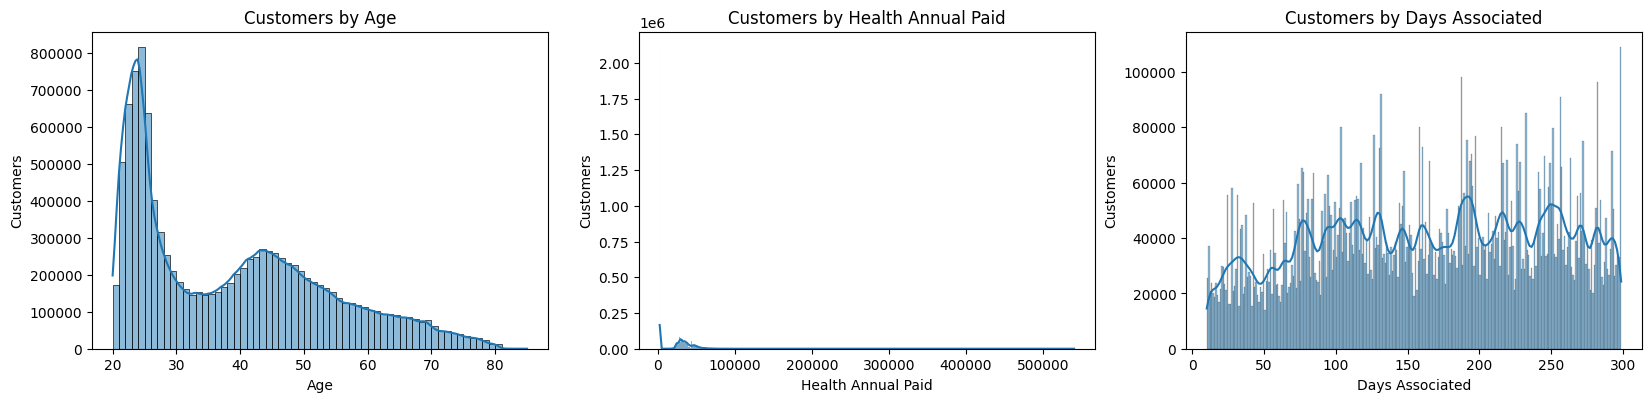

In [79]:
#Num Attributes plot
plt.figure(figsize=(20,14))

plt.subplot(3,3,1)
age_hist = sns.histplot(df['age'], binwidth=1, kde=True);
age_hist.set_ylabel('Customers')
age_hist.set_xlabel('Age')
age_hist.set_title('Customers by Age');

plt.subplot(3,3,2)
hap_hist = sns.histplot(df['annual_premium'], kde=True);
hap_hist.set_ylabel('Customers')
hap_hist.set_xlabel('Health Annual Paid')
hap_hist.set_title('Customers by Health Annual Paid');

plt.subplot(3,3,3)
da_hist = sns.histplot(df['vintage'], binwidth=1, kde=True);
da_hist.set_ylabel('Customers')
da_hist.set_xlabel('Days Associated')
da_hist.set_title('Customers by Days Associated');

In [ ]:
#Highlights:

#age: there is a peak at 25y/old
#health_annual_premium: very big range of 537535, high kurtosis, some extreme values.

## Cat Attributes

In [81]:
#variations of each column
print(f"- Distinct values:\n{cat_attributes.apply( lambda x: x.unique().shape[0] ) } \n" )
print(f"- Variations:\n{cat_attributes.apply( lambda x: x.unique() ) } " )

- Distinct values:
gender                    2
driving_license           2
region_code              53
previously_insured        2
vehicle_age               3
vehicle_damage            2
policy_sales_channel    152
response                  2
dtype: int64 

- Variations:
gender                                                     [Male, Female]
driving_license                                                    [1, 0]
region_code             [35, 28, 14, 1, 15, 47, 45, 8, 11, 3, 10, 12, ...
previously_insured                                                 [0, 1]
vehicle_age                               [1-2 Year, > 2 Years, < 1 Year]
vehicle_damage                                                     [1, 0]
policy_sales_channel    [124, 26, 152, 156, 160, 8, 31, 157, 60, 122, ...
response                                                           [0, 1]
dtype: object 


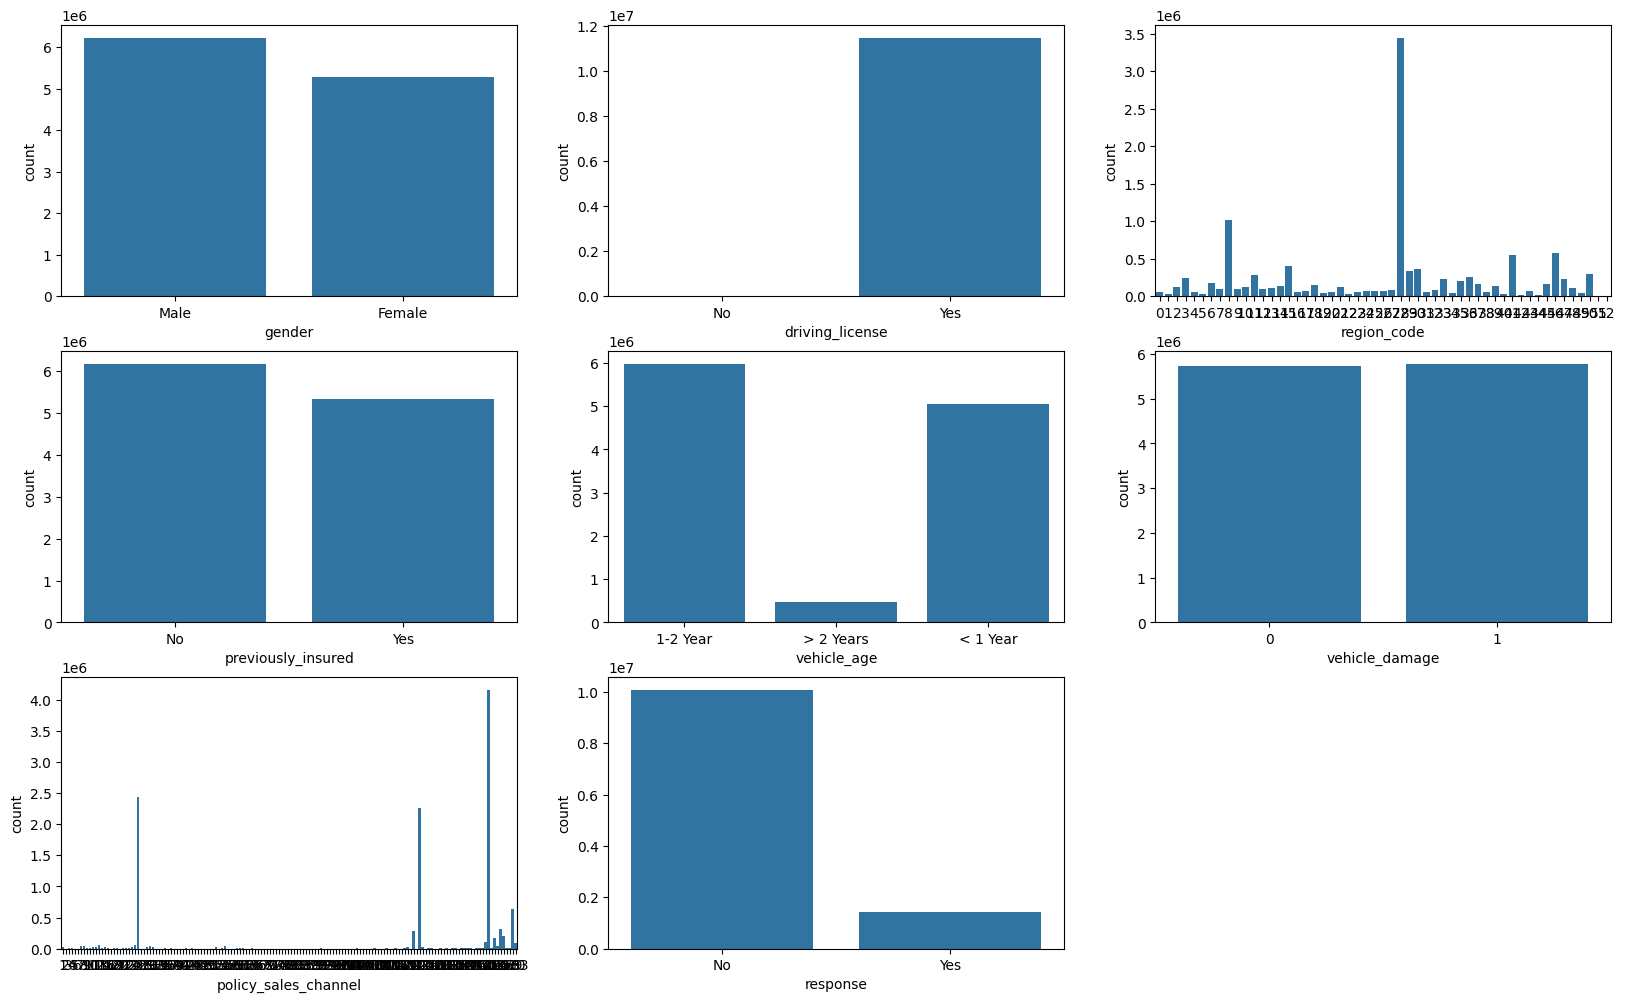

In [83]:
plt.figure(figsize=(20,12))

plt.subplot (3,3,1)
sns.countplot (x = cat_attributes['gender']);

plt.subplot (3,3,2)
sns.countplot (x = cat_attributes['driving_license']);
plt.xticks([0,1],['No','Yes']);

plt.subplot (3,3,3)
sns.countplot (x = cat_attributes['region_code']);

plt.subplot (3,3,4)
sns.countplot (x = cat_attributes['previously_insured']);
plt.xticks([0,1],['No','Yes']);

plt.subplot (3,3,5)
sns.countplot (x = cat_attributes['vehicle_age']);

plt.subplot (3,3,6)
sns.countplot (x = cat_attributes['vehicle_damage']);

plt.subplot (3,3,7)
sns.countplot (x = cat_attributes['policy_sales_channel']);

plt.subplot (3,3,8)
sns.countplot (x = cat_attributes['response']);
plt.xticks([0,1],['No','Yes']);


In [ ]:
#Highlights:
#region_code and policy_sales_channel: many variations, few with many customers
#driving_license: less than 1% has not.

In [91]:
df.driving_license.value_counts()

driving_license
1    11482041
0       22757
Name: count, dtype: int64

In [89]:
df.driving_license.value_counts(normalize=True)

driving_license
1   1.00
0   0.00
Name: proportion, dtype: float64

# Checkpoint 1

In [95]:
#df.to_parquet('..\\data\\v1\\chp1.parquet')

In [3]:
df = pd.read_parquet( '..\\data\\v1\\chp1.parquet')
print(df.shape)
df[:3]

(11504798, 12)


,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,0,Male,21,1,35,0,1-2 Year,1,65101,124,187,0
1,1,Male,43,1,28,0,> 2 Years,1,58911,26,288,1
2,2,Female,25,1,14,1,< 1 Year,0,38043,152,254,0


# Dataset Split

In [4]:
#try with 500k, to test CV methods
#df500k = df.sample(500000).reset_index(drop=True).copy()
df100k = df.sample(n=100000, random_state=98).reset_index(drop=True).copy()
#df500k = df.copy()

In [5]:
print(df100k.shape)
df100k[:2]

(100000, 12)


,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1095917,Female,31,1,2,0,1-2 Year,1,29684,124,76,0
1,1006411,Male,59,1,28,0,1-2 Year,1,54609,26,131,1


In [6]:
X = df100k.drop(columns="response") 
y = df100k.response

In [7]:
#split between train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 98, stratify = y, test_size = 0.20) #stratify by y

In [8]:
# train data
print('X_train -> ',X_train.shape)
print('y_train -> ',y_train.shape)
# test data
print('X_test -> ',X_test.shape)
print('y_test -> ',y_test.shape)

X_train ->  (80000, 11)
y_train ->  (80000,)
X_test ->  (20000, 11)
y_test ->  (20000,)


In [9]:
#destroy df
df=''

# EDA (jump)

# Data Prep (Jump)

In [10]:
# Catboost does not require data prep

In [11]:
#Trees do not require reescale, but require encoding, except CatBoost that does it internally.

In [12]:
#Drop ip:
X_train.drop(columns='id', inplace=True)
X_test.drop(columns='id', inplace=True)

# ML

## DecisionTreeClassifier

### CV and Fine Tuning

In [31]:
# GridSearch + Cross Validation

# dictionary of possible hiperparameters to test their combinations
param_grid_dt = {'max_depth': [4, 5],  'class_weight': [{0: 1, 1: 2.5}] }#  'class_weight': [None, 'balanced', {0: 1, 1: 2.5}  , 'max_leaf_nodes': [10, 40, 100]  , 'min_samples_leaf':[5, 20, 45], }
    #'class_weight': {0: 1, 1: 2.5} balancing manually, to give more importance to the minority class.
# -> max_leaf_nodes and min_samples_leaf did not improve the model's performance
print("Parameter grid DT:\n{}".format(param_grid_dt))

Parameter grid DT:
{'max_depth': [4, 5], 'class_weight': [{0: 1, 1: 2.5}]}


In [32]:
# instantiate a DT Classifier, on a GridSearchCV, and the number of K folds:
grid_src_DTClassif = GridSearchCV(DecisionTreeClassifier(random_state=98), param_grid_dt, cv=5, n_jobs=-1, scoring='roc_auc', return_train_score=True) #return_train_score=True 
    # GridSearchCV: will run CV for each combination of parameters (can be costly) 
    # Just like cross_val_score, GridSearchCV will use stratified k-fold cross-validation by default for classification, and k-fold for regression.
     #'refit'=True(default): will retrain a final model with all data (TRAIN and VAL), with the best CV parameters found against VAL.
     # this model will be in the GridSearchCV object, and its score is obtained by calling the 'score' method.

grid_src_DTClassif.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=98), n_jobs=-1,
             param_grid={'class_weight': [{0: 1, 1: 2.5}], 'max_depth': [4, 5]},
             return_train_score=True, scoring='roc_auc')

In [33]:
# Get best parameters, and also the best score with cross-validation (VAL DATA):
print("Best parameters (val): {}".format(grid_src_DTClassif.best_params_))
print("Best cross-validation score (val): {:.3f}".format(grid_src_DTClassif.best_score_))

Best parameters (val): {'class_weight': {0: 1, 1: 2.5}, 'max_depth': 5}
Best cross-validation score (val): 0.841


In [34]:
# Best model trained in VAL:
dt_best_estimator = grid_src_DTClassif.best_estimator_
print("DT Best estimator (val): {}".format(dt_best_estimator))

DT Best estimator (val): DecisionTreeClassifier(class_weight={0: 1, 1: 2.5}, max_depth=5,
                       random_state=98)


In [35]:
# Ranking of best models with CV, considering all given combinations of parameters. (mean_test_score = VAL):
pd.DataFrame(grid_src_DTClassif.cv_results_)[['rank_test_score','params','mean_train_score','mean_test_score']].sort_values('rank_test_score')[:5]

,rank_test_score,params,mean_train_score,mean_test_score
1,1,"{'class_weight': {0: 1, 1: 2.5}, 'max_depth': 5}",0.843,0.841
0,2,"{'class_weight': {0: 1, 1: 2.5}, 'max_depth': 4}",0.835,0.835


In [36]:
#best estimators - mean_test_score:
#v1 w 50k rows - 0.84
#v3 w/ 500k rows - 0.843
#v3 w/ 11.5M rows - no memmory to run
#v3 w/ 1500k rows (1.5m) - 0.844
# There was almost no improvement on getting more than 50k rows, to improve this model's performance. Others, maybe.

In [37]:
#Since target is not balanced, 'class_weight': 'balanced' was tried, but din't improve the model.

### Roc_Auc Metric

In [38]:
# Calculate ROC AUC score: This score evaluates the model's ability to distinguish between classes.
    # A higher AUC_ROC score implies better discrimination between positive and negative classes across various thresholds.
  
# Predict probabilities (ROC AUC score demands probabilities of class 1)
y_hat_dt_prob = dt_best_estimator.predict_proba(X_test)[:, 1]
# Calculate ROC AUC score
dt_roc_auc = roc_auc_score(y_test, y_hat_dt_prob)

print("RF Best Estimator (TEST) ROC AUC Score: {:.3f}".format(dt_roc_auc))

RF Best Estimator (TEST) ROC AUC Score: 0.839


In [39]:
#Submission -> Kaggle Public Score: 0.794 

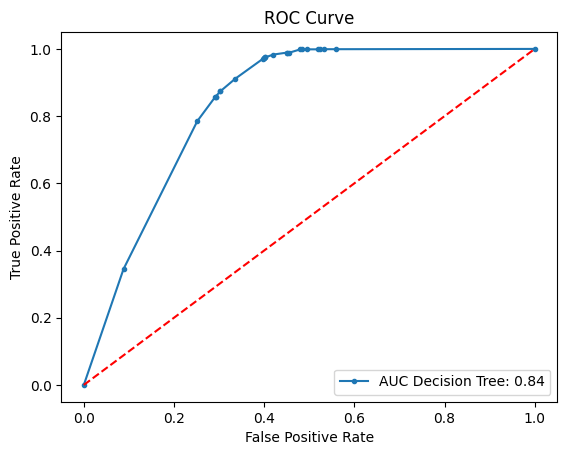

In [40]:
#Plot ROC CURVE using predict_proba:

# calculate roc curve
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test, y_hat_dt_prob);
# calculate AUC
roc_auc_dt = auc(fpr_dt, tpr_dt);
# plot the roc curve for the model
plt.plot(fpr_dt, tpr_dt, marker='.', label='AUC Decision Tree: %0.2f' % roc_auc_dt);
plt.plot([0, 1], [0, 1], color='red', linestyle='--');
# axis labels
plt.title("ROC Curve"); #built using predict_proba
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');

# Display the legend
plt.legend();
#Plot of the closest point to 0.5  -> does not mattet here
# Find the index of the point closest to 0.5 (because I'm using predict_proba)
#closest_to_0_5 = np.argmin(np.abs(thresholds - 0.5))
# plt.plot(fpr[closest_to_0_5], tpr[closest_to_0_5], 'o', markersize=10, label="threshold 0.5 (default)", fillstyle="none", c='k', mew=2)
# plt.legend(loc=4)
# plt.show();

### Confusion Matrix

In [41]:
#PS: Just to have an overview of model predictions. It won't help improve ROC_AUC, because it show the results over 1 thresholds, and ROC_AUC consider the predictions across all of them.

In [42]:
# Convention: 
    # Positive class: 1. It's the less representative, the anomaly, the one we want to forecast. Here, it is: which customers respond positively to an automobile insurance offer.
    # Negative class: 0. The most representative.

In [43]:
#the matrix below is inverted, compared to the one in the literature, but it was what the GPT chat suggested, and it is correct and makes sense.

In [44]:
#Get prediction of DT model
y_pred_dt = dt_best_estimator.predict(X_test)
y_pred_dt[0:5]

array([1, 0, 1, 0, 0])

Teve [17552] Não Aceitou | Previ [13661] 
Teve [2448] Aceitou | Previ [6339]


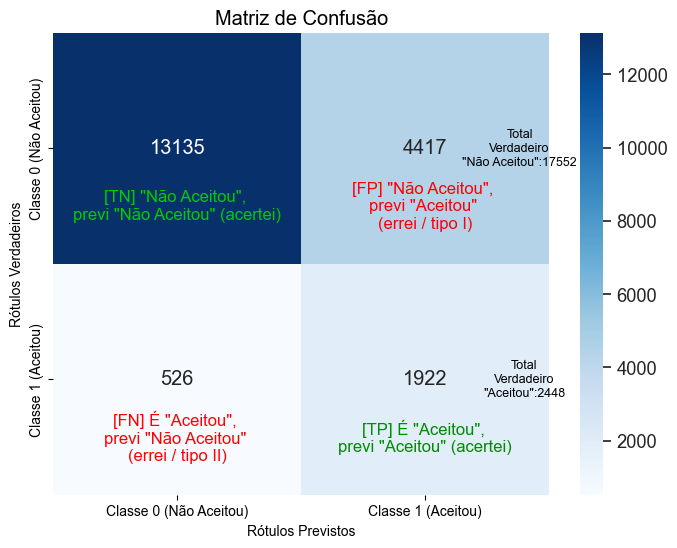

In [50]:
#{'class_weight': {0: 1, 1: 2.5}, 'max_depth': 5}	

#plot confusion matrix
conf_matrix_detailed(y_test, y_pred_dt, 'Aceitou', 'Não Aceitou')

In [51]:
#To improve ROC_AUC, it's necessary to improve predictions on both classes.

## RandomForestClassifier

### CV and Fine Tuning

In [52]:
# GridSearch + Cross Validation

# dictionary of possible hiperparameters to test their combinations
param_grid_rf = {'max_depth': [3, 5],  'class_weight': ['balanced', {0: 1, 1: 2.5} ], }#  'class_weight': [None, 'balanced', {0: 1, 1: 2.5}  , 'max_leaf_nodes': [10, 40, 100]  , 'min_samples_leaf':[5, 20, 45], }
    #'class_weight': {0: 1, 1: 2.5} balancing manually, to give more importance to the minority class.
# -> max_leaf_nodes and min_samples_leaf did not improve the model's performance
print("Parameter grid RF:\n{}".format(param_grid_rf))

Parameter grid RF:
{'max_depth': [3, 5], 'class_weight': ['balanced', {0: 1, 1: 2.5}]}


In [53]:
# instantiate a DT Classifier, on a GridSearchCV, and the number of K folds:
grid_src_RFClassif = GridSearchCV(RandomForestClassifier(n_estimators=50, random_state=98), param_grid_rf, cv=5, n_jobs=-1, scoring='roc_auc', return_train_score=True)
grid_src_RFClassif.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(n_estimators=50, random_state=98),
             n_jobs=-1,
             param_grid={'class_weight': ['balanced', {0: 1, 1: 2.5}],
                         'max_depth': [3, 5]},
             return_train_score=True, scoring='roc_auc')

In [54]:
# Get best parameters, and also the best score with cross-validation (VAL DATA):
print("RF Best parameters (val): {}".format(grid_src_RFClassif.best_params_))
print("RF Best cross-validation score (val): {:.3f}".format(grid_src_RFClassif.best_score_))

RF Best parameters (val): {'class_weight': {0: 1, 1: 2.5}, 'max_depth': 5}
RF Best cross-validation score (val): 0.851


In [55]:
# Best model trained in VAL:
rf_best_estimator = grid_src_RFClassif.best_estimator_
print("RF Best estimator (val): {}".format(rf_best_estimator))

RF Best estimator (val): RandomForestClassifier(class_weight={0: 1, 1: 2.5}, max_depth=5,
                       n_estimators=50, random_state=98)


In [56]:
# Ranking of best models with CV, considering all given combinations of parameters. (mean_test_score = VAL):
pd.DataFrame(grid_src_RFClassif.cv_results_)[['rank_test_score','params','mean_train_score','mean_test_score']].sort_values('rank_test_score')[:5]

,rank_test_score,params,mean_train_score,mean_test_score
3,1,"{'class_weight': {0: 1, 1: 2.5}, 'max_depth': 5}",0.855,0.851
1,2,"{'class_weight': 'balanced', 'max_depth': 5}",0.855,0.851
2,3,"{'class_weight': {0: 1, 1: 2.5}, 'max_depth': 3}",0.845,0.843
0,4,"{'class_weight': 'balanced', 'max_depth': 3}",0.843,0.842


### Roc_Auc Metric

In [57]:
# Calculate ROC AUC score: This score evaluates the model's ability to distinguish between classes.
    # A higher AUC_ROC score implies better discrimination between positive and negative classes across various thresholds.
  
# Predict probabilities (ROC AUC score demands probabilities of class 1)
y_hat_rf_prob = rf_best_estimator.predict_proba(X_test)[:, 1]
# Calculate ROC AUC score
rf_roc_auc = roc_auc_score(y_test, y_hat_rf_prob)

print("RF Best Estimator (TEST) ROC AUC Score: {:.3f}".format(rf_roc_auc))

RF Best Estimator (TEST) ROC AUC Score: 0.848


In [63]:
#Submission -> Kaggle Public Score: 0.853 (submitting using predict_proba instead of predict)

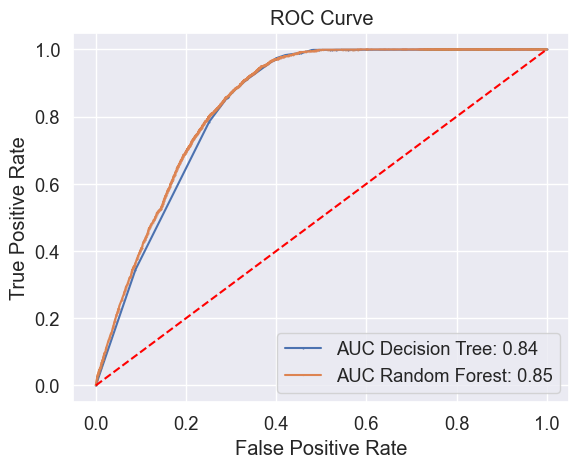

In [58]:
#Plot ROC CURVE using predict_proba:

# calculate roc curve
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_hat_rf_prob);
# calculate AUC
roc_auc_rf = auc(fpr_rf, tpr_rf);

# plot the roc curve for the model
# decision tree:
plt.plot(fpr_dt, tpr_dt, marker='.', markersize=1, label='AUC Decision Tree: %0.2f' % roc_auc_dt);
# random forest:
plt.plot(fpr_rf, tpr_rf, marker='.', markersize=.1, label='AUC Random Forest: %0.2f' % roc_auc_rf);

plt.plot([0, 1], [0, 1], color='red', linestyle='--');
# axis labels
plt.title("ROC Curve"); #built using predict_proba
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');

# Display the legend
plt.legend();
plt.show();

In [59]:
#Random Forest is slightly better than DT.

## Logistic Regression

In [94]:
#Demands reescaling
X_train[:2]

,id,is_male,age,driving_license,region_code,previously_insured,vehicle_damage,annual_premium,policy_sales_channel,vintage,vehicle_age_below_1_y,vehicle_age_bet_1-2_y,vehicle_age_over_2_y
51417,9286176,1,65,1,20,0,1,2630,124,219,0,1,0
27769,2004849,1,32,1,28,0,1,37991,26,183,0,1,0


In [100]:
#I will assume non normal distribution by now, and keep going with MinMaxScaller for every feature
MMS_scaler = MinMaxScaler()
X_train_scaled = MMS_scaler.fit_transform(X_train)

In [102]:
X_train_scaled[:1]

array([[0.807158, 1.      , 0.714286, 1.      , 0.384615, 0.      ,
        1.      , 0.      , 0.759259, 0.723183, 0.      , 1.      ,
        0.      ]])

### LogisticRegressionCV

In [ ]:
#Without CrossValCV, and fine tuning

In [104]:
# Initialize LogisticRegressionCV
logRegCV_model = LogisticRegressionCV(cv=5, scoring='roc_auc', max_iter=1000, random_state=98)

# Fit the model to the training data
logRegCV_model.fit(X_train_scaled, y_train)

LogisticRegressionCV(cv=5, max_iter=1000, random_state=98, scoring='roc_auc')

#### Roc_Auc Metric

In [106]:
#Scale Test Data:
X_test_scaled = MMS_scaler.transform(X_test)
X_test_scaled[:1]

array([[0.248853, 1.      , 0.206349, 1.      , 0.942308, 0.      ,
        1.      , 0.      , 0.154321, 0.179931, 0.      , 1.      ,
        0.      ]])

In [109]:
# Calculate ROC AUC score: This score evaluates the model's ability to distinguish between classes.
    # A higher AUC_ROC score implies better discrimination between positive and negative classes across various thresholds.
  
# Predict probabilities (ROC AUC score demands probabilities of class 1)
y_hat_prob_lr = logRegCV_model.predict_proba(X_test_scaled)[:, 1]
# Calculate ROC AUC score
lr_roc_auc = roc_auc_score(y_test, y_hat_prob_lr)

print("RF Best Estimator (TEST) ROC AUC Score: {:.3f}".format(lr_roc_auc))

RF Best Estimator (TEST) ROC AUC Score: 0.838


In [110]:
# Without rescaling: 0.831 on test.
# Rescaling with MinMaxScaller: 0.838 on test (slightly better)

#Submission -> Kaggle Public Score:

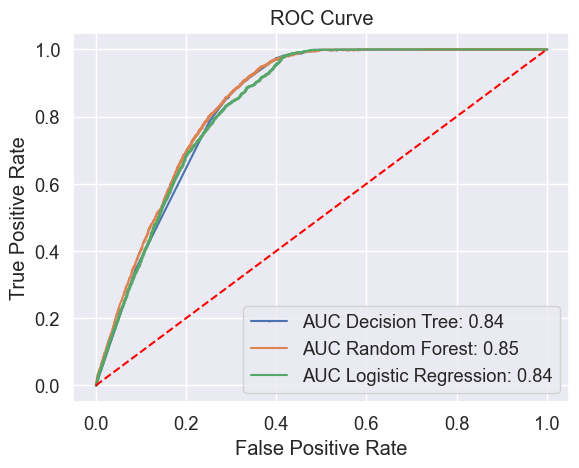

In [111]:
#Plot ROC CURVE using predict_proba:

# calculate roc curve
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_hat_prob_lr);
# calculate AUC
roc_auc_lr = auc(fpr_lr, tpr_lr);

# plot the roc curve for the models
# decision tree:
plt.plot(fpr_dt, tpr_dt, marker='.', markersize=1, label='AUC Decision Tree: %0.2f' % roc_auc_dt);
# random forest:
plt.plot(fpr_rf, tpr_rf, marker='.', markersize=.1, label='AUC Random Forest: %0.2f' % roc_auc_rf);
# logistic regression:
plt.plot(fpr_lr, tpr_lr, marker='.', markersize=.1, label='AUC Logistic Regression: %0.2f' % roc_auc_lr);

plt.plot([0, 1], [0, 1], color='red', linestyle='--');
# axis labels
plt.title("ROC Curve"); #built using predict_proba
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');

# Display the legend
plt.legend();
plt.show();

In [59]:
#Random Forest is slightly better than the rest.

### LogisticRegression + Fine Tunign

In [129]:
# Define the parameter grid
lr_param_grid = {
    'penalty': ['l1', 'l2'],  # Regularization penalty
    'C': [1, 10, 100],  # Inverse of regularization strength #10 was chosen, so removec < 1
    'solver': ['liblinear','newton-cholesky'],  # Solver to use; 
        #'liblinear' supports l1 and l2 penalties
    'max_iter': [2000]  # Maximum number of iterations  
}
print("Parameter grid LR:\n{}".format(lr_param_grid))

Parameter grid LR:
{'penalty': ['l1', 'l2'], 'C': [1, 10, 100], 'solver': ['liblinear', 'newton-cholesky'], 'max_iter': [2000]}


In [130]:
# Initialize the logistic regression model with fine tuning

# GridSearchCV
grid_src_lr = GridSearchCV(LogisticRegression(random_state=98), param_grid=lr_param_grid, cv=5, n_jobs=-1, scoring='roc_auc', return_train_score=True)

# Fit GridSearchCV to the training data
grid_src_lr.fit(X_train_scaled, y_train)

C:\Users\norton\repos\play_s4e7_ins_cross\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
15 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\norton\repos\play_s4e7_ins_cross\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\norton\repos\play_s4e7_ins_cross\.venv\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\norton\repos\play_s4e7_ins_cross\

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=98), n_jobs=-1,
             param_grid={'C': [1, 10, 100], 'max_iter': [2000],
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'newton-cholesky']},
             return_train_score=True, scoring='roc_auc')

In [131]:
# Get best parameters, and also the best score with cross-validation (VAL DATA):
print("LR W/ Fine Tuning Best parameters (val): {}".format(grid_src_lr.best_params_))
print("LR W/ Fine Tuning Best cross-validation score (val): {:.3f}".format(grid_src_lr.best_score_))

LR W/ Fine Tuning Best parameters (val): {'C': 10, 'max_iter': 2000, 'penalty': 'l1', 'solver': 'liblinear'}
LR W/ Fine Tuning Best cross-validation score (val): 0.840


In [132]:
# Ranking of best models with CV, considering all given combinations of parameters. (mean_test_score = VAL):
pd.DataFrame(grid_src_lr.cv_results_)[['rank_test_score','params','mean_train_score','mean_test_score']].sort_values('rank_test_score')[:5]

,rank_test_score,params,mean_train_score,mean_test_score
4,1,"{'C': 10, 'max_iter': 2000, 'penalty': 'l1', 'solver': 'liblinear'}",0.840,0.840
3,2,"{'C': 1, 'max_iter': 2000, 'penalty': 'l2', 'solver': 'newton-cholesky'}",0.840,0.840
6,3,"{'C': 10, 'max_iter': 2000, 'penalty': 'l2', 'solver': 'liblinear'}",0.840,0.840
7,4,"{'C': 10, 'max_iter': 2000, 'penalty': 'l2', 'solver': 'newton-cholesky'}",0.840,0.840
10,5,"{'C': 100, 'max_iter': 2000, 'penalty': 'l2', 'solver': 'liblinear'}",0.840,0.840


#### Roc_Auc Metric

In [133]:
# Calculate ROC AUC score: This score evaluates the model's ability to distinguish between classes.
    # A higher AUC_ROC score implies better discrimination between positive and negative classes across various thresholds.
  
# Predict probabilities (ROC AUC score demands probabilities of class 1)
y_hat_prob_lr_ft = grid_src_lr.predict_proba(X_test_scaled)[:, 1]
# Calculate ROC AUC score
lr_ft_roc_auc = roc_auc_score(y_test, y_hat_prob_lr_ft)

print("RF Best Estimator (TEST) ROC AUC Score: {:.3f}".format(lr_ft_roc_auc))

RF Best Estimator (TEST) ROC AUC Score: 0.839


In [ ]:
# Without Fine Tuning: 0.838 on test
# With Fine Tuning: 0.839 on test (slightly better)

In [110]:
#Submission -> Kaggle Public Score: 0.841 (v4)

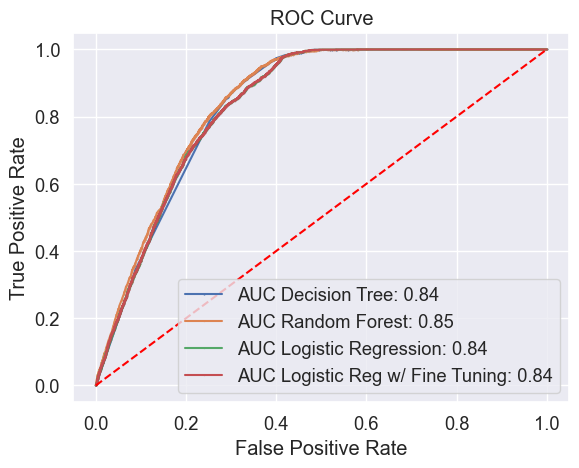

In [135]:
#Plot ROC CURVE using predict_proba:

# calculate roc curve
fpr_lrft, tpr_lrft, thresholds_lrft = roc_curve(y_test, y_hat_prob_lr_ft);
# calculate AUC
roc_auc_lrft = auc(fpr_lrft, tpr_lrft);

# plot the roc curve for the models
# decision tree:
plt.plot(fpr_dt, tpr_dt, marker='.', markersize=1, label='AUC Decision Tree: %0.2f' % roc_auc_dt);
# random forest:
plt.plot(fpr_rf, tpr_rf, marker='.', markersize=.1, label='AUC Random Forest: %0.2f' % roc_auc_rf);
# logistic regression:
plt.plot(fpr_lr, tpr_lr, marker='.', markersize=.1, label='AUC Logistic Regression: %0.2f' % roc_auc_lr);
# logistic regression w/ Fine Tuning:
plt.plot(fpr_lrft, tpr_lrft, marker='.', markersize=.1, label='AUC Logistic Reg w/ Fine Tuning: %0.2f' % roc_auc_lrft);

plt.plot([0, 1], [0, 1], color='red', linestyle='--');
# axis labels
plt.title("ROC Curve"); #built using predict_proba
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');

# Display the legend
plt.legend();
plt.show();

In [ ]:
#Random Forest is still better. 

## CatBoostClassifier

### [Balanced]

In [13]:
# Balance CatBoost
    #By default, CatBoostClassifier does not automatically balance classes in a binary classification problem.
    #If your dataset is imbalanced, you need to handle this explicitly using parameters such as scale_pos_weight or class_weights.

In [15]:
X_train[:2]

,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage
51417,Male,65,1,20,0,1-2 Year,1,2630,124,219
27769,Male,32,1,28,0,1-2 Year,1,37991,26,183


In [16]:
# Assuming the positive class is labeled as 1 and the negative class as 0
# Calculate the scale_pos_weight
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
scale_pos_weight

7.169934640522876

In [17]:
#Identify categorical features:
categorical_columns = ['gender', 'driving_license', 'vehicle_age','vehicle_damage']

# Replace 'categorical_feature_indices' with the indices or names of your categorical columns
categorical_features_indices = [X_train.columns.get_loc(col) for col in categorical_columns]
print(categorical_features_indices)

[0, 2, 5, 6]


In [18]:
#Initialize and train the CatBoostClassifier:
# Initialize CatBoostClassifier
cb_model = CatBoostClassifier(
    #scale_pos_weight=scale_pos_weight, #balance classes  -> did not improve anything
    class_weights=[1, scale_pos_weight],
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    eval_metric='AUC',
    random_seed=98,
    logging_level='Verbose',
    use_best_model=True
)

# Train the model
cb_model.fit(
    X_train, y_train,
    cat_features=categorical_features_indices,
    eval_set=(X_test, y_test),
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.8150244	best: 0.8150244 (0)	total: 258ms	remaining: 4m 17s
1:	test: 0.8244357	best: 0.8244357 (1)	total: 358ms	remaining: 2m 58s
2:	test: 0.8244739	best: 0.8244739 (2)	total: 408ms	remaining: 2m 15s
3:	test: 0.8339027	best: 0.8339027 (3)	total: 460ms	remaining: 1m 54s
4:	test: 0.8405515	best: 0.8405515 (4)	total: 515ms	remaining: 1m 42s
5:	test: 0.8465719	best: 0.8465719 (5)	total: 568ms	remaining: 1m 34s
6:	test: 0.8468476	best: 0.8468476 (6)	total: 618ms	remaining: 1m 27s
7:	test: 0.8464865	best: 0.8468476 (6)	total: 666ms	remaining: 1m 22s
8:	test: 0.8464409	best: 0.8468476 (6)	total: 717ms	remaining: 1m 18s
9:	test: 0.8467328	best: 0.8468476 (6)	total: 773ms	remaining: 1m 16s
10:	test: 0.8468068	best: 0.8468476 (6)	total: 821ms	remaining: 1m 13s
11:	test: 0.8468739	best: 0.8468739 (11)	total: 871ms	remaining: 1m 11s
12:	test: 0.8473392	best: 0.8473392 (12)	total: 918ms	remaining: 1m 9s
13:	test: 0.8481083	best: 0.8481083 (13)	total: 968ms	remaining: 1m 8s
14:	test: 0.848

In [20]:
#params used
cb_model.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'AUC',
 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1'],
 'iterations': 1000,
 'sampling_frequency': 'PerTree',
 'fold_permutation_block': 0,
 'leaf_estimation_method': 'Newton',
 'random_score_type': 'NormalWithModelSizeDecrease',
 'counter_calc_method': 'SkipTest',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'ctr_leaf_count_limit': 18446744073709551615,
 'bayesian_matrix_reg': 0.10000000149011612,
 'one_hot_max_size': 2,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': False,
 'max_ctr_complexity': 4,
 'model_size_reg': 0.5,
 'simple_ctr': ['Borders:CtrBorderCount=15:CtrBorderType

#### Roc_Auc Metric

In [22]:
# Calculate ROC AUC score: This score evaluates the model's ability to distinguish between classes.
    # A higher AUC_ROC score implies better discrimination between positive and negative classes across various thresholds.
  
# Predict probabilities (ROC AUC score demands probabilities of class 1)
y_prob_cb = cb_model.predict_proba(X_test)[:, 1]
# Calculate ROC AUC score
roc_auc_cb = roc_auc_score(y_test, y_prob_cb)

print("CB Best Estimator (TEST) ROC AUC Score: {:.3f}".format(roc_auc_cb))

CB Best Estimator (TEST) ROC AUC Score: 0.862


In [23]:
#First time >.86!

In [24]:
# Without rescaling: 0.831 on test.
# Rescaling with MinMaxScaller: 0.838 on test (slightly better)

#Submission -> Kaggle Public Score:

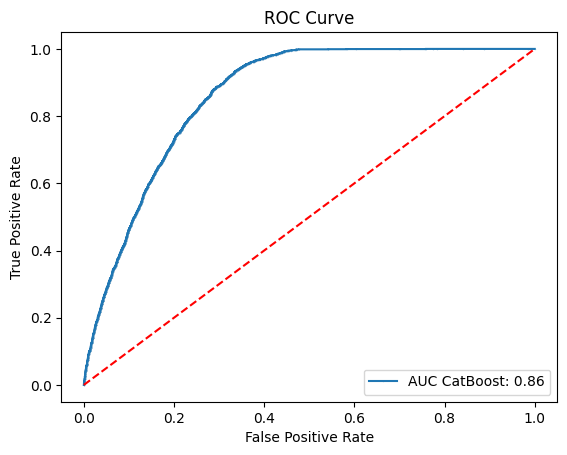

In [25]:
#Plot ROC CURVE using predict_proba:

# calculate roc curve
fpr_cb, tpr_cb, thresholds_cb = roc_curve(y_test, y_prob_cb);
# calculate AUC
roc_auc_cb = auc(fpr_cb, tpr_cb);

# plot the roc curve for the models
# decision tree:
#plt.plot(fpr_dt, tpr_dt, marker='.', markersize=1, label='AUC Decision Tree: %0.2f' % roc_auc_dt);
# random forest:
#plt.plot(fpr_rf, tpr_rf, marker='.', markersize=.1, label='AUC Random Forest: %0.2f' % roc_auc_rf);
# logistic regression:
#plt.plot(fpr_lr, tpr_lr, marker='.', markersize=.1, label='AUC Logistic Regression: %0.2f' % roc_auc_lr);
# catboost:
plt.plot(fpr_cb, tpr_cb, marker='.', markersize=.1, label='AUC CatBoost: %0.2f' % roc_auc_cb);

plt.plot([0, 1], [0, 1], color='red', linestyle='--');
# axis labels
plt.title("ROC Curve"); #built using predict_proba
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');

# Display the legend
plt.legend();
plt.show();

In [ ]:
# Did not compare to all other because would need to run all transformations ans models, and than this. 

### [GridSearchCV]

In [13]:
# Balance CatBoost
    #By default, CatBoostClassifier does not automatically balance classes in a binary classification problem.
    #If your dataset is imbalanced, you need to handle this explicitly using parameters such as scale_pos_weight or class_weights.

In [26]:
X_train[:2]

,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage
51417,Male,65,1,20,0,1-2 Year,1,2630,124,219
27769,Male,32,1,28,0,1-2 Year,1,37991,26,183


In [47]:
#Identify categorical features:
categorical_columns = ['gender', 'driving_license', 'vehicle_age','vehicle_damage']

# Replace 'categorical_feature_indices' with the indices or names of your categorical columns
categorical_features_indices = [X_train.columns.get_loc(col) for col in categorical_columns]
print(categorical_features_indices)

[0, 2, 5, 6]


In [48]:
#Grid Search
gs_cb_param_grid = {
    'iterations': [5000], #[500]
    'learning_rate':  [0.05],  #[0.01, 0.05, 0.1]
    'depth': [9],  #[6, 8],
    'l2_leaf_reg': [0.5] #[1, 3]
}
print("Parameter grid CatBoost:\n{}".format(gs_cb_param_grid))

Parameter grid CatBoost:
{'iterations': [5000], 'learning_rate': [0.05], 'depth': [9], 'l2_leaf_reg': [0.5]}


In [50]:
#CatBoostClassifier
gs_cb_model = CatBoostClassifier(
    eval_metric='AUC',
    random_seed=98,
    logging_level='Verbose',#Silent
    use_best_model=True
)

# Instance GS + CB
gs_cb_model = GridSearchCV(estimator=gs_cb_model, param_grid=gs_cb_param_grid, cv=3, scoring='roc_auc', n_jobs=-1, verbose=2) #return_train_score=True

# Train the model
gs_cb_model.fit(
    X_train, y_train,
    cat_features=categorical_features_indices,
    eval_set=(X_test, y_test),
    plot=True
)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.8416036	best: 0.8416036 (0)	total: 89.5ms	remaining: 7m 27s
1:	test: 0.8419160	best: 0.8419160 (1)	total: 183ms	remaining: 7m 37s
2:	test: 0.8435420	best: 0.8435420 (2)	total: 290ms	remaining: 8m 2s
3:	test: 0.8430668	best: 0.8435420 (2)	total: 316ms	remaining: 6m 34s
4:	test: 0.8442786	best: 0.8442786 (4)	total: 409ms	remaining: 6m 48s
5:	test: 0.8449464	best: 0.8449464 (5)	total: 499ms	remaining: 6m 55s
6:	test: 0.8453318	best: 0.8453318 (6)	total: 590ms	remaining: 7m 1s
7:	test: 0.8462018	best: 0.8462018 (7)	total: 664ms	remaining: 6m 54s
8:	test: 0.8468487	best: 0.8468487 (8)	total: 756ms	remaining: 6m 59s
9:	test: 0.8471469	best: 0.8471469 (9)	total: 860ms	remaining: 7m 9s
10:	test: 0.8476171	best: 0.8476171 (10)	total: 922ms	remaining: 6m 57s
11:	test: 0.8486599	best: 0.8486599 (11)	total: 1.02s	remaining: 7m 2s
12:	test: 0.8492458	best: 0.8492458 (12)	total: 1.1s	remaining: 7m 1s
13:	test: 0.8500680	best: 0.8500680 (13)	total: 1.19s	remaining: 7m 2s
14:	test: 0.850799

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x000001F866012CC0>,
             n_jobs=-1,
             param_grid={'depth': [9], 'iterations': [5000],
                         'l2_leaf_reg': [0.5], 'learning_rate': [0.05]},
             scoring='roc_auc', verbose=2)

In [51]:
# Get best parameters, and also the best score with cross-validation (TEST DATA):
print("CB Best parameters (TEST): {}".format(gs_cb_model.best_params_))
print("CB Best cross-validation score (TEST): {:.3f}".format(gs_cb_model.best_score_))

CB Best parameters (TEST): {'depth': 9, 'iterations': 5000, 'l2_leaf_reg': 0.5, 'learning_rate': 0.05}
CB Best cross-validation score (TEST): 0.860


In [52]:
# Train the model with the best parameters  -> NOT NEEDED! (use_best_model=True)
#best_gs_cb_model = gs_cb_model.best_estimator_

#### Roc_Auc Metric

In [53]:
# Calculate ROC AUC score: This score evaluates the model's ability to distinguish between classes.
    # A higher AUC_ROC score implies better discrimination between positive and negative classes across various thresholds.

# Predict probabilities
y_prob_gs_cb = gs_cb_model.predict_proba(X_test)[:, 1]
# Calculate ROC AUC score
roc_auc_gs_cb = roc_auc_score(y_test, y_prob_gs_cb)
print("CB Best Estimator (TEST) ROC AUC Score: {:.3f}".format(roc_auc_gs_cb))

CB Best Estimator (TEST) ROC AUC Score: 0.858


In [ ]:
# CB without GS: 0.862
# With GS, sugested by chat gpt: 0.860 (worst)
# With GS, like Kaggle's [AutoML Grand Prix] 1st Place Solution: 0.858 (worst)
    #{'iterations': [5000], 'learning_rate': [0.05], 'depth': [9], 'l2_leaf_reg': [0.5]} 
    #More data?
    #Feature eng?

# Kaggle Test Prediction

In [54]:
# Load .csv w/ Pandas (production data, to submit predictions)
X_prod = pd.read_csv('..\\data\\kaggle\\test.csv')
#save id to build submission
X_prod_id = X_prod['id'].copy()
X_prod.drop(columns='id', inplace=True)
#convert all cols to lower case, and replace spaces and dots with underscores
X_prod.columns = X_prod.columns.str.replace(' ','_').str.replace('.','_').str.lower()
print(X_prod.shape) #7 MI rows!
X_prod[:3]

(7669866, 10)


,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage
0,Female,20,1,47.000,0,< 1 Year,No,2630.000,160.000,228
1,Male,47,1,28.000,0,1-2 Year,Yes,37483.000,124.000,123
2,Male,47,1,43.000,0,1-2 Year,Yes,2630.000,26.000,271


## Transform data (Jump)

In [56]:
#predict on prod data:
y_hat_prod = gs_cb_model.predict_proba(X_prod)[:,1]

In [57]:
#Predictions done:
print(y_hat_prod.shape)
y_hat_prod[:5]

(7669866,)


array([0.011822, 0.349504, 0.266958, 0.000316, 0.313378])

In [58]:
# Prepare for submission: id + predictions:
# Create final dataset
df_sub = pd.concat([ pd.Series(X_prod_id, name='id') , pd.Series(y_hat_prod, name='Target') ], axis=1)
df_sub[:3]

,id,Target
0,11504798,0.012
1,11504799,0.350
2,11504800,0.267


In [60]:
# Export to submit on Kaggle
df_sub.to_csv('..\\data\\v6\\submission_v6.csv', index=False)